In [1]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS, FIRE, MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units, Atoms
from ase.calculators.lj import LennardJones
from sklearn.metrics import mean_squared_error
import pandas as pd
import seaborn as sns

sns.set_style("white")
sns.set_context("notebook")

from castle import ASEMLCalculator, AceRepresentation, LPEnsemble, LinearPotential, ExpandedPotential
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}

%load_ext autoreload
%autoreload 2

In [ ]:
N = 4
maxdeg = 12
e_noise = 1e-8
f_noise = 1e-6
# e_lin, f_lin, e_ens, f_ens, e_exp, f_exp = {}, {}, {}, {}, {}, {}
n_clusters = {'Cu':5, 'Li':2, 'Ni':6, 'Mo':7, 'Si':2, 'Ge':3 }

In [19]:
for species in list(rcuts.keys()):
    root = f"/home/claudio/postdoc/data/Zuo/{species}/"

    print(species)
    rcut = rcuts[species]
    force_name = 'dft_forces'
    energy_name = 'DFT_PE'

    
    try:
        e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
            root, "train_trajectory.xyz", "validation_trajectory.xyz",
            f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz", f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
            force_name = force_name, energy_name =energy_name)
    except FileNotFoundError:
        tr_features, val_features = utils.extract_features(root , "train_trajectory.xyz", "validation_trajectory.xyz",
                                                     N=N, maxdeg=maxdeg, rcut=rcut, force_name = force_name, energy_name = energy_name,
                                                    species = species)
        e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
            root, "train_trajectory.xyz", "validation_trajectory.xyz",
            f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz", f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
            force_name = force_name, energy_name =energy_name)

        representation = tr_features.representation
    
    model_lin = LinearPotential(representation)
    model_lin.fit_from_features(tr_features, e_t, f_t, noise_optimization=False)
    predictions = model_lin.predict_from_features(val_features, forces=True)
    ep = predictions['energy']
    fp = predictions['forces']
    e_lin[species] = np.abs(ep/nat_val -  e_val/nat_val)
    f_lin[species] = np.sum((fp - f_val)**2, axis = -1)**0.5
    
#     rmse_e_ = np.inf
#     rmse_f_ = np.inf
#     for n_clusters in np.arange(2, 10):
#         model_ens =  LPEnsamble(representation, n_clusters=n_clusters, clustering_type='kmeans', baseline_percentile=0)
#         model_ens.fit_from_features(tr_features, e_t, f_t, noise)
#         predictions = model_ens.predict_from_features(val_features, forces=True)
#         ep = predictions['energy']
#         fp = predictions['forces']
#         rmse_e = mean_squared_error(ep/nat_val, e_val/nat_val, squared=False)
#         rmse_f = mean_squared_error(fp.flatten(), f_val.flatten(), squared=False)
        
#         if (rmse_e*3 + rmse_f) < 0.95*(rmse_e_*3 + rmse_f_):
#             rmse_f_ = rmse_f
#             rmse_e_ = rmse_e
#             nclusters[species] = n_clusters
#             print(n_clusters, rmse_e, rmse_f)
            
    model_ens =  LPEnsemble(representation, n_clusters=n_clusters[species], clustering_type='kmeans', baseline_percentile=0)
    model_ens.fit_from_features(tr_features, e_t, f_t, noise_optimization=False)
    predictions = model_ens.predict_from_features(val_features, forces=True)
    ep = predictions['energy']
    fp = predictions['forces']
    e_ens[species] = np.abs(ep/nat_val -  e_val/nat_val)
    f_ens[species] = np.sum((fp - f_val)**2, axis = -1)**0.5
    
    
    model_exp = ExpandedPotential(representation, D=1000)
    model_exp.fit_from_features(tr_features, e_t, f_t, e_noise, f_noise, noise_optimization=False, iterations=1)
    predictions = model_exp.predict_from_features(val_features, forces=True)
    ep = predictions['energy']
    fp = predictions['forces']
    e_exp[species] = np.abs(ep/nat_val -  e_val/nat_val)
    f_exp[species] = np.sum((fp - f_val)**2, axis = -1)**0.5

Cu
Clustering data
Using 5 clusters
Mo
Clustering data
Using 7 clusters
Si
Clustering data
Using 2 clusters
Ge
Clustering data
Using 3 clusters
Ni
Clustering data
Using 6 clusters
Li
Clustering data
Using 2 clusters


In [10]:
df_e = pd.DataFrame()
df_f = pd.DataFrame()

for s in rcuts.keys():
    df_ = pd.DataFrame()
    df_['Energy Error [meV/atom]'] = np.array(1000*e_lin[s])
    df_['Model'] = 'linear'
    df_['Species'] = s
    df_e = df_e.append(df_)

    df_ = pd.DataFrame()
    df_['Energy Error [meV/atom]'] = np.array(1000*e_ens[s])
    df_['Model'] = 'ensemble'
    df_['Species'] = s
    df_e = df_e.append(df_)
    
    df_ = pd.DataFrame()
    df_['Energy Error [meV/atom]'] = np.array(1000*e_exp[s])
    df_['Model'] = 'expanded'
    df_['Species'] = s
    df_e = df_e.append(df_)

    df_ = pd.DataFrame()
    df_['Force Error [eV/$\AA$]'] = np.array(f_lin[s])/np.sqrt(3)
    df_['Model'] = 'linear'
    df_['Species'] = s
    df_f = df_f.append(df_)

    df_ = pd.DataFrame()
    df_['Force Error [eV/$\AA$]'] = np.array(f_ens[s])/np.sqrt(3)
    df_['Model'] = 'ensemble'
    df_['Species'] = s
    df_f = df_f.append(df_)

    df_ = pd.DataFrame()
    df_['Force Error [eV/$\AA$]'] = np.array(f_exp[s])/np.sqrt(3)
    df_['Model'] = 'expanded'
    df_['Species'] = s
    df_f = df_f.append(df_)
    
df_f['Force Squared Error'] = df_f['Force Error [eV/$\AA$]']**2
df_e['Energy Squared Error'] = df_e['Energy Error [meV/atom]']**2

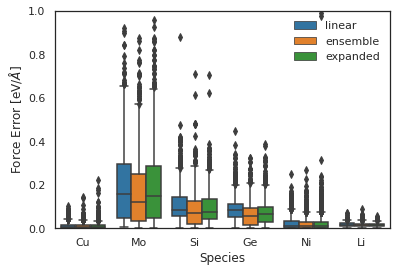

In [11]:
sns.boxplot(data = df_f, x = 'Species', y = 'Force Error [eV/$\AA$]', hue = 'Model')
plt.ylim(0, 1)
plt.legend(frameon=False)
plt.savefig("/home/claudio/postdoc/plots/linear_vs_ensemble_zuo_forces_noiseopt.pdf")

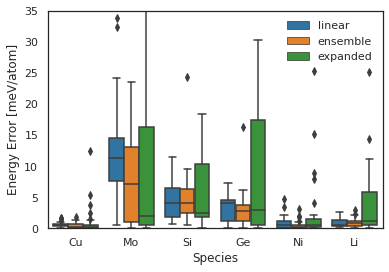

In [12]:
sns.boxplot(data = df_e, x = 'Species', y = 'Energy Error [meV/atom]', hue = 'Model')
plt.ylim(0, 35)
plt.legend(frameon=False)
plt.savefig("/home/claudio/postdoc/plots/linear_vs_ensemble_zuo_energy_noiseopt.pdf")

In [13]:
df_e.groupby(['Species', 'Model'])['Energy Squared Error'].describe()['mean']**0.5

Species  Model   
Cu       ensemble     0.610895
         expanded     2.609386
         linear       0.722555
Ge       ensemble    16.016811
         expanded    18.815270
         linear      13.129430
Li       ensemble     1.154098
         expanded     6.656305
         linear       1.204005
Mo       ensemble    10.705134
         expanded    55.770508
         linear      16.463140
Ni       ensemble     0.832605
         expanded    11.507146
         linear       1.343057
Si       ensemble     6.713806
         expanded    29.786662
         linear       5.363037
Name: mean, dtype: float64

In [16]:
df_f.groupby(['Species', 'Model'])['Force Squared Error'].describe()['mean']**0.5

Species  Model   
Cu       ensemble    0.016551
         expanded    0.018066
         linear      0.019339
Ge       ensemble    0.082706
         expanded    0.088814
         linear      0.102747
Li       ensemble    0.018719
         expanded    0.017493
         linear      0.019299
Mo       ensemble    0.237142
         expanded    0.282048
         linear      0.264902
Ni       ensemble    0.034066
         expanded    0.044316
         linear      0.038689
Si       ensemble    0.114369
         expanded    0.116495
         linear      0.134063
Name: mean, dtype: float64

In [17]:
df_f.to_csv("Zuo_forces_test.csv")

In [18]:
df_e.to_csv("Zuo_energies_test.csv")